# Object detection using tensorflow api

The first step will be converting our data into a tensorflow record file, as described in these step-by-step instructions that I'm following: 
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_locally.md

### Converting our fashion data set into a tensorflow record file

Tutorial: http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/

In [7]:
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

import hashlib
import io
import logging
import os
import random
import re

from lxml import etree
import numpy as np
import PIL.Image
import tensorflow as tf

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

image = '/Users/lisa/sandbox/iMaterialist_Challenge/data/tmm_dataset_sharing/image/92890.jpg'

/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/lisa/.pyenv/versions/3.6.0/envs/imaterialist/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


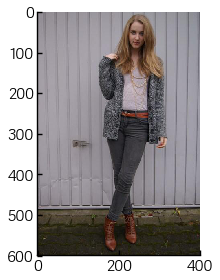

In [3]:
fashion_img = io.imread(image)
io.imshow(fashion_img)

In [5]:
fashion_string = fashion_img.tostring() # raw data bytes from a numpy array

actually first let's understand the file format for an example (pet) data set. we should have the images and then a mask

In [9]:
img_path = '/Users/lisa/Downloads/images/Abyssinian_1.jpg'
mask_path = '/Users/lisa/Downloads/annotations/trimaps/Abyssinian_1.png'

In [27]:
with tf.gfile.GFile(img_path, 'rb') as fid:
    encoded_jpg = fid.read()
encoded_jpg_io = io.BytesIO(encoded_jpg)
image = PIL.Image.open(encoded_jpg_io)
image_np = np.asarray(image)
print(image.format)

JPEG


In [18]:
with tf.gfile.GFile(mask_path, 'rb') as fid:
    encoded_mask_png = fid.read()
encoded_png_io = io.BytesIO(encoded_mask_png)
mask = PIL.Image.open(encoded_png_io)
print(mask.format)

PNG


In [23]:
mask_np = np.asarray(mask)
print(set(mask_np.flatten())) #make sure there are different values in this set.
print(np.shape(mask_np)) # the array is a numerical array that is the same size as the image. As expected.

{1, 2, 3}
(400, 600)


In [24]:
tfrecords_filename = 'pet_test.tfrecords'

writer = tf.python_io.TFRecordWriter(tfrecords_filename)


In [30]:
height, width, rgb = np.shape(image_np)

In [47]:
# the mask should have everything be zero that isn't the item of interest
#can put in loop if more than on label in image
masks = []
mask_remapped = (mask_np != 2).astype(np.uint8)
masks.append(mask_remapped)

In [53]:
encoded_mask_png_list = []
for mask in masks:
    img = PIL.Image.fromarray(mask)
    output = io.BytesIO()
    img.save(output, format='PNG')
    encoded_mask_png_list.append(output.getvalue())

In [55]:
# should also put the corresponding class name
feature_dict = {
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
      'image/object/mask': dataset_util.bytes_list_feature(encoded_mask_png_list)
}

example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
# print(example)

In [56]:
tf_example = example
writer.write(tf_example.SerializeToString())

In [57]:
writer.close()

I'm going to naively start with the same pipeline configuration as the pet training example.
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_pets.md

" In the object_detection/samples/configs folder, there are skeleton object_detection configuration files. We will use faster_rcnn_resnet101_pets.config as a starting point for configuring the pipeline. Open the file with your favourite text editor."

### Making tensorflow records file for the fashion dataset

In [59]:
import h5py
f = h5py.File('../data/tmm_dataset_sharing/fashon_parsing_data.hdf5', 'r')
data = f.get('#refs#')
keys = list(data.keys()) # each key has the data about an image

In [83]:
def rotate_seg_data(seg_data):
    rotated = np.rot90(seg_data)
    rotated = np.rot90(rotated)
    rotated = np.rot90(rotated)
    return rotated

In [87]:
def decode_color_category_labels(seg_data):
    '''Input is a segmented image. Output is the image with color or category labels'''
    
    seg_data = rotate_seg_data(seg_data)
    shape = np.shape(seg_data)
    pixels = seg_data.flatten()

    pix_colors = []
    pix_labels = []
    for pix in pixels:
        pix = int(pix)
        color = color_label[pix]-1 # off by 1 because these were originally matlab files
        label = category_label[pix]-1 #off by 1 because these were originally matlab files
        pix_colors.append(color)
        pix_labels.append(label)
        
    return pix_colors, pix_labels, shape

In [88]:
# write a function to do that tensorflow thing.
# for an individual image, we want to look at the category labels and create masks

def create_tf_example(img_path, categorized_array):
    with tf.gfile.GFile(img_path, 'rb') as fid:
        encoded_jpg = fid.read()
        encoded_jpg_io = io.BytesIO(encoded_jpg)
        image = PIL.Image.open(encoded_jpg_io)
        image_np = np.asarray(image)
    height, width, rgb = np.shape(image_np)
    
    print(height, width)
    print(np.shape(categorized_array))
    
    image_categories = list(set(categorized_array.flatten()))
    encoded_mask_png_list = []
    classes = []
    
    for cat in image_categories:
        mask_remapped = (categorized_array == cat).astype(np.uint8)
        img = PIL.Image.fromarray(mask_remapped)
        output = io.BytesIO()
        img.save(output, format='PNG')
        encoded_mask_png_list.append(output.getvalue())
        classes.append(int(cat))
        
    # from pet example
    # class_name = get_class_name_from_filename(data['filename'])
    #  classes_text.append(class_name.encode('utf8'))
    #  classes.append(label_map_dict[class_name])
        
    feature_dict = {
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
      'image/object/mask': dataset_util.bytes_list_feature(encoded_mask_png_list), 
      'image/object/class/label': dataset_util.int64_list_feature(classes),
        }

    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
        
    #encoded_jpg, encoded_mask_png_list, [height, width], image_categories
    
    return example

In [90]:
count = 0
tfrecords_filename = 'fashion_test.tfrecords'

writer = tf.python_io.TFRecordWriter(tfrecords_filename)
BASE_IMAGE_PATH = '/Users/lisa/sandbox/iMaterialist_Challenge/data/tmm_dataset_sharing/image/'
for key in keys:
    if count<10:
        image_data = data.get(key)
        segment_data = image_data.get('segmentation').value
        color_label = image_data.get('color_label').value[0]
        category_label = image_data.get('category_label').value[0]
        img_numbers = image_data.get('img_name').value
        
        
        image_name = ''
        for num in img_numbers:
            image_name += chr(num[0])
        print(image_name)
        color_image_flattened, label_image_flattened, shape = decode_color_category_labels(segment_data)
        
        new_color_image = np.reshape(color_image_flattened, shape)
        new_label_image = np.reshape(label_image_flattened, shape)
        
        image_path = BASE_IMAGE_PATH + '{}'.format(image_name)
        tf_example = create_tf_example(image_path, new_label_image)
        writer.write(tf_example.SerializeToString())

    count+=1
    
writer.close()

32160.jpg
600 400
(600, 400)
169304.jpg
600 400
(600, 400)
100221.jpg
600 400
(600, 400)
102919.jpg
600 400
(600, 400)
134447.jpg
600 400
(600, 400)
103419.jpg
600 400
(600, 400)
169934.jpg
600 400
(600, 400)
180677.jpg
600 400
(600, 400)
86159.jpg
600 400
(600, 400)
38182.jpg
600 400
(600, 400)
